# Lyrics Classification Part 1: Converting Text into Vectors Using Bag of Words
In this notebook I show how to build a features matrix from song lyrics scraped from the web. The features are columns of each word occurring in any single song. Each column contains counts of the word frequency within the song, normalized by the frequency of the word within the entire scraped lyrics corpus. The goal is to classify a song as belonging to a particular artist. The concept is that any artist will likely have particular words they frequently use, by which the model can identify them.

I execute the following steps:
- Read in the song files from the Data directory
- Prepare the data by creating tokens of the words (lemmatization) and removing stop words
- Select only two artists to create a binary classification problem. Multiple classification will be discussed in Lyrics Classification part 2
- Feature engineer by creating columns of normalized word frequencies for each word (i.e. building a dataframe of several thousand columns)
- Fit a Naive-Bayes model to the training data
- Score the model
- Plot the precision-recall curve

**Prerequisites**: Run the script webscraping.py in your terminal in order to scrape the songs from the web and save the files in the Data directory

## Import external libraries

In [1]:
import warnings
import pandas as pd
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import RandomOverSampler
import spacy
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

## Import functions from script

In [2]:
import functions as func

## 1. Read song files
- Read names of song files into a list

In [3]:
print('1. Reading data...\n')
songFiles = [f for f in os.listdir('Data/Webscraping/song_lyrics') if not f.startswith(".")]
    

1. Reading data...



## 2. Prepare data
- Load bag of words model from spacy
- Read song files and separate artist, song lyrics and song titles
- Clean song lyrics by removing new line characters
- Tokenize relevant words
    - Include only alpha-numeric characters
    - Remove stop words and punctuation
    - Reduce words to their word stems, also known as lemmatization (e.g. "jumping" -> "jump")
- Return list of tokenized song lyrics
- Create dataframe with columns:
    - artist
    - tokenized song lyrics
    - song title (only for quality control)

In [4]:
print('2. Preparing data...\n')
filepath = "Data/Webscraping/song_lyrics/"
model = spacy.load('en_core_web_sm') 

[artists, songLyrics, songTitles] = func.read_lyricsFiles(songFiles, filepath)
songLyrics_cleaned = func.clean_and_tokenize_lyrics(songLyrics, model)

2. Preparing data...



In [5]:
df = func.create_dataframe_lyrics(artists, songLyrics_cleaned, songTitles)
df_binary = df[(df['artist'] == "Bob-Dylan") | (df['artist'] == "Jay-Z") ]
y = df_binary.artist
X = df_binary.lyrics

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify= y)

In [6]:
df.head()

,artist,lyrics,songTitle
0,Whitney-Houston,lie Heaven hear lose cause give winter storm c...,I Look to You
1,Mumford-%26-Sons,wanna turn away time different line cruel kind...,Wona
2,Jay-Z,Rocafella millionaire bitch early right haha h...,Big Spender
3,Adele,leave goodbye single word say final kiss seal ...,Don't You Remember
4,Lady-Gaga,oh tonight go to killer queen inside come hell...,The Queen


## 3. Feature engineer
- Count number of occurrences of each token/word in the lyrics column
- Normalize count using tf-idf transformer, i.e. divide the term frequency by the inverse of the document frequency
- Return dataframe containing the count densities of each word per song
    - Each word in the entire lyrics corpus is a column in the dataframe

In [7]:
print('3. Feature Engineering...\n')
cv = CountVectorizer(stop_words='english')
tf = TfidfTransformer()    
vec_corpus_train = cv.fit_transform(X_train)
vec_corpus_test = cv.transform(X_test)

tf_corpus_train = tf.fit_transform(vec_corpus_train)
tf_corpus_test = tf.transform(vec_corpus_test)

X_train_tfdf = func.tfdf_bow(cv, tf_corpus_train)
X_test_tfdf = func.tfdf_bow(cv, tf_corpus_test)

3. Feature Engineering...



In [8]:
X_train_tfdf

,aa,ab,abandon,aberdeen,abide,abiti,able,abortion,absence,absent,...,youth,youtube,yup,zapatos,zero,zimmerman,zo,zone,zoo,ɲi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.08,0.0,0.0,0.0,0.0,0.0
801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0


### Some data issues using the bag of words model
There are some unusual words/columns in the training data:
- Chinese characters that are not filtered out by the model and seem to be part of the model's English vocabulary
- Many different forms of the word yes/yea
- Particularly unusual words such as "yaknahmsayin" which seem more like typos
- Words such as "fighting" that I would expect to be reduced to "fight"
    - The lemma of "fighting" is "fight", but this can also depend on the context of the word in the sentence ("there is no more fighting")

Unusual words are fairly harmless, as they are not likely to be part of many other songs and hence not particularly selective. However, many different ways of writing "yea"/"ye"/"yeh"/... is problematic, as each has its separate column. It might be interesting to summarize such common words written differently. Even if they are common in many songs (high document frequency), the term frequency can be characteristic of a particular artist.

In [9]:
pd.DataFrame(X_train_tfdf.columns).tail(50)

,0
4875,wrist
4876,write
4877,writer
4878,writing
4879,wrong
4880,ws
4881,wu
4882,xxl
4883,xy
4884,ya


In [10]:
model("look to you\n\nAfter losing my breath\nThere's no more fighting left\nSinking to rise no more\nSearching for")[13].lemma_

'fighting'

In [11]:
model("fighting")[0].lemma_

'fighting'

In [12]:
'진짜' in model.vocab

True

In [13]:
'vocabbdskjfb' in model.vocab

False

## 4. Fit Naive-Bayes model to binary classes
- Binary classes are imbalanced
- Balance classes using oversampling
- Train Naive-Bayes models on the imbalanced and balanced datasets

In [14]:
y_train.value_counts()

Bob-Dylan    454
Jay-Z        349
Name: artist, dtype: int64

In [15]:
clf_nb = MultinomialNB()
clf_nb.fit(X_train_tfdf, y_train)

MultinomialNB()

In [16]:
ros = RandomOverSampler(sampling_strategy = 'not majority')
X_resampled, y_resampled = ros.fit_resample(X_train_tfdf, y_train)
y_resampled.value_counts()

Jay-Z        454
Bob-Dylan    454
Name: artist, dtype: int64

In [18]:
clf_nb_sampled = MultinomialNB()
clf_nb_sampled.fit(X_resampled, y_resampled)

MultinomialNB()

## 5. Score model
- Binary classification with Naive-Bayes shows a high accuracy of 97.4%, i.e. number of true positives over total
- Precision and recall are also very high at > 96 % for either class
- The number of misclassified samples are 10 out of 268 for Naive-Bayes, and 7 out of 268 for Naive-Bayes with oversampling

In [20]:
func.print_model_scores(clf_nb, X_train_tfdf, X_test_tfdf, y_train, y_test)

Training Score: 0.9726027397260274
Testing Score: 0.9626865671641791


Text(0.5, 1.0, 'Naive-Bayes with oversampling')

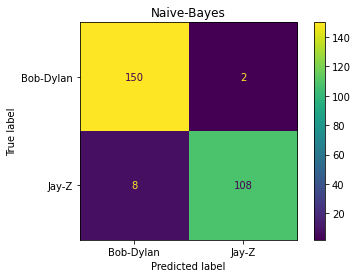

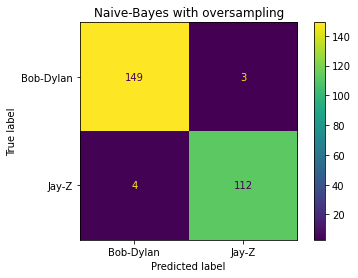

In [28]:
metrics.plot_confusion_matrix(clf_nb, X_test_tfdf, y_test, normalize=None)
plt.title("Naive-Bayes")
metrics.plot_confusion_matrix(clf_nb_sampled, X_test_tfdf, y_test, normalize=None)
plt.title("Naive-Bayes with oversampling")

### Precision score
- sklearn: "The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative."
- The precision score does not care about the number of false negatives!
- E.g. How many of the predicted Bob Dylan's were actually Bob Dylan? 149/153 = 0.974

In [22]:
metrics.precision_score(y_test, clf_nb_sampled.predict(X_test_tfdf), average = None)

array([0.97385621, 0.97391304])

### Recall score
- sklearn: "The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative."
- The recall score does not care about false positives!
- E.g. How many of the actual Bob Dylan's were predicted as Bob Dylan? 149 / 152 = 0.98

In [23]:
metrics.recall_score(y_test, clf_nb_sampled.predict(X_test_tfdf), average = None)

array([0.98026316, 0.96551724])

### Precision-Recall curve
- Precision and recall are somewhat conflicting measures: Usually tuning the model to perfect one of the scores comes at the price of the other score. This is particularly important when classes are imbalanced
- E.g. To predict all the actuals and get a recall of 100 %, the number of false positives will likely increase, which means that the precision of the model will suffer
- The curve shows computed precision-recall pairs for different probability thresholds of the classifier

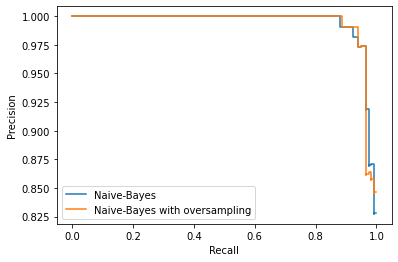

In [24]:
disp = metrics.plot_precision_recall_curve(clf_nb, X_test_tfdf, y_test, label='Naive-Bayes')
metrics.plot_precision_recall_curve(clf_nb_sampled, X_test_tfdf, y_test, ax=disp.ax_, label='Naive-Bayes with oversampling')

## Accuracy
- Number of true positives over total (bad measure for unbalanced classes)

In [31]:
metrics.accuracy_score(y_test, clf_nb_sampled.predict(X_test_tfdf))

0.9738805970149254